In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import math
import seaborn as sns

print("[INFO] Libraries loaded successfully.")

[INFO] Libraries loaded successfully.


In [ ]:
LOAD_DIR = "/content/drive/MyDrive/car_damage_detection"

trainX = np.load(f"{LOAD_DIR}/trainX.npy")
trainY = np.load(f"{LOAD_DIR}/trainY.npy")
testX  = np.load(f"{LOAD_DIR}/testX.npy")
testY  = np.load(f"{LOAD_DIR}/testY.npy")

print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("testX :", testX.shape)
print("testY :", testY.shape)

trainX: (1840, 224, 224, 3)
trainY: (1840, 2)
testX : (460, 224, 224, 3)
testY : (460, 2)


In [ ]:
print(testX[0])

[[[-0.7647059  -0.7254902  -0.7019608 ]
  [-0.6862745  -0.64705884 -0.62352943]
  [-0.4980392  -0.4352941  -0.41176468]
  ...
  [-0.23137254 -0.21568626 -0.23921567]
  [-0.26274508 -0.24705881 -0.27058822]
  [-0.26274508 -0.24705881 -0.27058822]]

 [[-0.7647059  -0.7254902  -0.7019608 ]
  [-0.7019608  -0.6627451  -0.6392157 ]
  [-0.56078434 -0.4980392  -0.47450978]
  ...
  [-0.23921567 -0.2235294  -0.24705881]
  [-0.26274508 -0.24705881 -0.27058822]
  [-0.26274508 -0.24705881 -0.27058822]]

 [[-0.77254903 -0.73333335 -0.70980394]
  [-0.73333335 -0.69411767 -0.67058825]
  [-0.64705884 -0.58431375 -0.5686275 ]
  ...
  [-0.15294117 -0.1372549  -0.1607843 ]
  [-0.1372549  -0.12156862 -0.14509803]
  [-0.1372549  -0.12156862 -0.14509803]]

 ...

 [[-0.88235295 -0.8666667  -0.8745098 ]
  [-0.8745098  -0.85882354 -0.8666667 ]
  [-0.8745098  -0.85882354 -0.8666667 ]
  ...
  [-0.58431375 -0.5529412  -0.7490196 ]
  [-0.73333335 -0.69411767 -0.8666667 ]
  [-0.73333335 -0.69411767 -0.8666667 ]]

 [

In [ ]:
# --- Load base MobileNetV2 model ---
baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# --- Add custom classification head ---
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# --- Combine base & head ---
model = Model(inputs=baseModel.input, outputs=headModel)

# --- Freeze base layers (train only top) ---
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Model created successfully.")
model.summary()

/tmp/ipython-input-806057595.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet",


[INFO] Model created successfully.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
INIT_LR = 1e-5     # learning rate
EPOCHS = 100
# --- Compile model ---
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Model compiled.")

[INFO] Model compiled.


In [ ]:
import math

BS = 32            # batch size
factor = 8

# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),      # ~ rotation_range=20deg
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.2, 0.2),
], name="data_augmentation")

def augment(x, y):
    x = data_augmentation(x, training=True)  # random each batch
    return x, y

def identity(x, y):
    return x, y

print("[INFO] Data augmentation ready.")

[INFO] Data augmentation ready.


In [ ]:
# --- Callbacks ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mobilenetv2.h5", monitor="val_accuracy", save_best_only=True)

# --- Build tf.data pipelines ---

# base dataset (infinite)
base_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(len(trainX)).repeat()

orig_dataset = base_ds.batch(BS).map(identity, num_parallel_calls=tf.data.AUTOTUNE)
aug_dataset  = base_ds.batch(BS).map(augment,  num_parallel_calls=tf.data.AUTOTUNE)

# 3) mix them 50/50
mixed_dataset = tf.data.Dataset.sample_from_datasets(
    [orig_dataset, aug_dataset], weights=[0.5, 0.5]
).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = factor * math.ceil(len(trainX) / BS)

# --- Train ---
print("[INFO] Training started...")
H = model.fit(
    mixed_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)
print("[INFO] Training completed.")

[INFO] Training started...
Epoch 1/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5375 - loss: 2.9566

464/464 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.5376 - loss: 2.9550 - val_accuracy: 0.7913 - val_loss: 0.5318
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6773 - loss: 1.0887

464/464 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.6773 - loss: 1.0884 - val_accuracy: 0.8391 - val_loss: 0.3739
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7490 - loss: 0.6496

464/464 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.7490 - loss: 0.6495 - val_accuracy: 0.8500 - val_loss: 0.3313
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7769 - loss: 0.5224

464/464 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.7769 - loss: 0.5224 - val_accuracy: 0.8848 - val_loss: 0.3049
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8037 - loss: 0.4430

464/464 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.8037 - loss: 0.4430 - val_accuracy: 0.8957 - val_loss: 0.2911
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8206 - loss: 0.4082

464/464 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.8206 - loss: 0.4082 - val_accuracy: 0.9109 - val_loss: 0.2847
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.8296 - loss: 0.3849 - val_accuracy: 0.9087 - val_loss: 0.2787
Epoch 8/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.8390 - loss: 0.3681 - val_accuracy: 0.9109 - val_loss: 0.2722
Epoch 9/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8476 - loss: 0.3590

464/464 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.8476 - loss: 0.3590 - val_accuracy: 0.9130 - val_loss: 0.2640
Epoch 10/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.8587 - loss: 0.3453 - val_accuracy: 0.9043 - val_loss: 0.2590
Epoch 11/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.8597 - loss: 0.3189 - val_accuracy: 0.9065 - val_loss: 0.2598
Epoch 12/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.8620 - loss: 0.3289 - val_accuracy: 0.9043 - val_loss: 0.2519
Epoch 13/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.8769 - loss: 0.2924 - val_accuracy: 0.9087 - val_loss: 0.2477
Epoch 14/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8791 - loss: 0.2953

464/464 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.8791 - loss: 0.2953 - val_accuracy: 0.9152 - val_loss: 0.2478
Epoch 15/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.8768 - loss: 0.2908 - val_accuracy: 0.9109 - val_loss: 0.2453
Epoch 16/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.8823 - loss: 0.2800 - val_accuracy: 0.9152 - val_loss: 0.2409
Epoch 17/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8892 - loss: 0.2619

464/464 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.8892 - loss: 0.2619 - val_accuracy: 0.9174 - val_loss: 0.2345
Epoch 18/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.8783 - loss: 0.2839 - val_accuracy: 0.9130 - val_loss: 0.2353
Epoch 19/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.8899 - loss: 0.2623 - val_accuracy: 0.9130 - val_loss: 0.2353
Epoch 20/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.8931 - loss: 0.2613 - val_accuracy: 0.9130 - val_loss: 0.2364
Epoch 21/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.8967 - loss: 0.2555 - val_accuracy: 0.9152 - val_loss: 0.2344
Epoch 22/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9009 - loss: 0.2442 - val_accuracy: 0.9130 - val_loss: 0.2356
Epoch 23/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8947 - loss: 0.2591

464/464 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.8947 - loss: 0.2591 - val_accuracy: 0.9196 - val_loss: 0.2272
Epoch 24/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - accuracy: 0.8953 - loss: 0.2559 - val_accuracy: 0.9130 - val_loss: 0.2278
Epoch 25/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9041 - loss: 0.2359 - val_accuracy: 0.9196 - val_loss: 0.2297
Epoch 26/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9024 - loss: 0.2469 - val_accuracy: 0.9152 - val_loss: 0.2309
Epoch 27/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.9014 - loss: 0.2374 - val_accuracy: 0.9196 - val_loss: 0.2255
Epoch 28/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.9060 - loss: 0.2312 - val_accuracy: 0.9152 - val_loss: 0.2270
Epoch 29/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.9128 - loss: 0.2188 - val_accuracy: 0.9152 - val_loss: 0.2287
Epoch 30/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9075 - loss: 0.2214 - val_a

464/464 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.9150 - loss: 0.2149 - val_accuracy: 0.9217 - val_loss: 0.2257
Epoch 35/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.9077 - loss: 0.2224 - val_accuracy: 0.9196 - val_loss: 0.2231
Epoch 36/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9201 - loss: 0.2046 - val_accuracy: 0.9217 - val_loss: 0.2270
Epoch 37/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.9180 - loss: 0.2006 - val_accuracy: 0.9196 - val_loss: 0.2248
Epoch 38/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.9195 - loss: 0.2006 - val_accuracy: 0.9196 - val_loss: 0.2247
[INFO] Training completed.


In [ ]:
# --- Save trained model ---
model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_Final.keras")

[INFO] Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
              precision    recall  f1-score   support

   00-damage       0.90      0.93      0.92       230
    01-whole       0.93      0.90      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460



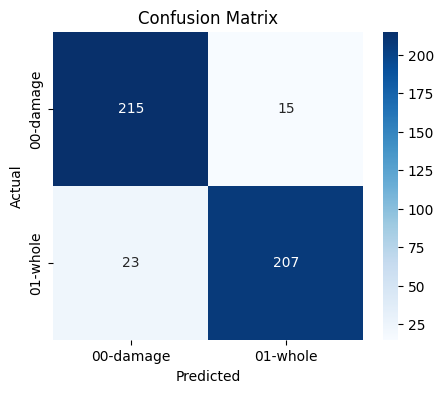

In [ ]:
# --- Evaluate model ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(testY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

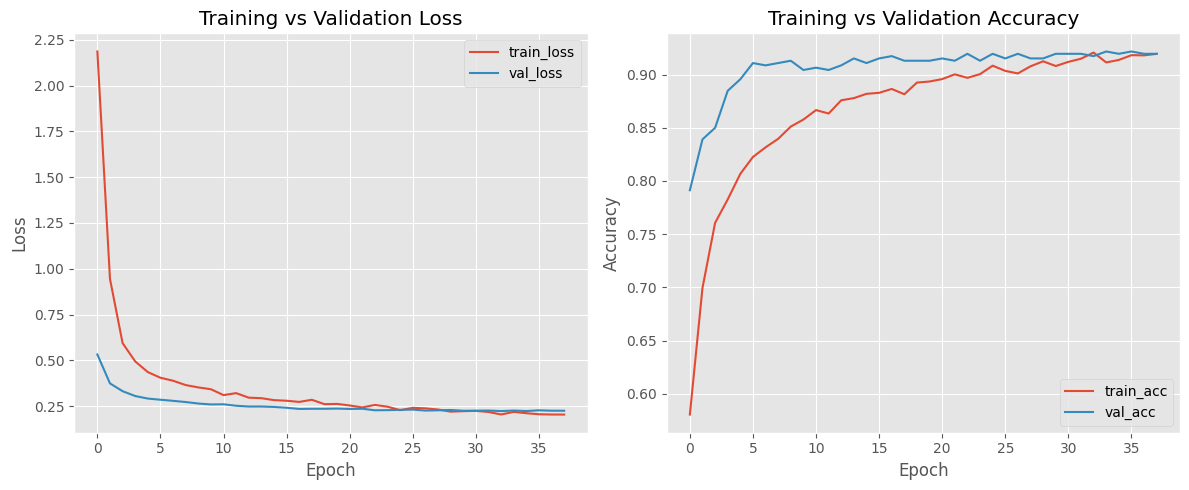

In [ ]:
# --- Plot accuracy/loss curves ---
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

print("[INFO] Unfreezing last 20 layers of MobileNetV2 for fine‑tuning...")

#--- Unfreeze some layers in the base model ---
for layer in baseModel.layers[-20:]:
    layer.trainable = True

#--- Re‑compile with smaller learning rate ---
opt_finetune = Adam(learning_rate=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=opt_finetune, metrics=["accuracy"])

print("[INFO] Model recompiled for fine‑tuning with lower LR and last 20 layers trainable.")

#--- Optional class weighting if you care more about "damage" detection ---
class_weight = {0: 1.0, 1: 1.0}  # keep if you want higher recall for "damage"

#--- Define new training parameters ---
EPOCHS_FINETUNE = 10
BS = 32
steps_per_epoch = factor * math.ceil(len(trainX) / BS)  # reuse your augmentation factor

print("[INFO] Starting fine‑tuning phase...")

#--- Fine‑tune using your existing tf.data *mixed_dataset* ---
H_finetune = model.fit(
    mixed_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=(testX, testY),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint]
)

print("[INFO] Fine‑tuning completed!")

[INFO] Unfreezing last 20 layers of MobileNetV2 for fine‑tuning...
[INFO] Model recompiled for fine‑tuning with lower LR and last 20 layers trainable.
[INFO] Starting fine‑tuning phase...
Epoch 1/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8491 - loss: 0.3778

464/464 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - accuracy: 0.8491 - loss: 0.3778 - val_accuracy: 0.9239 - val_loss: 0.2234
Epoch 2/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - accuracy: 0.8579 - loss: 0.3458 - val_accuracy: 0.9109 - val_loss: 0.2302
Epoch 3/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - accuracy: 0.8684 - loss: 0.3257 - val_accuracy: 0.9130 - val_loss: 0.2361
Epoch 4/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.8765 - loss: 0.3050 - val_accuracy: 0.9152 - val_loss: 0.2361
Epoch 5/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 825s 2s/step - accuracy: 0.8837 - loss: 0.2914 - val_accuracy: 0.9174 - val_loss: 0.2349
Epoch 6/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 849s 2s/step - accuracy: 0.8837 - loss: 0.2799 - val_accuracy: 0.9174 - val_loss: 0.2334
[INFO] Fine‑tuning completed!


In [ ]:
#--- Save the updated model ---

model.save("/content/drive/MyDrive/car_damage_detection/MobileNet_Car_detection_FineTuned.keras")
print("[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras")

[INFO] Fine‑tuned model saved as MobileNet_Car_detection_FineTuned.keras


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
[INFO] Best threshold = 0.472
[INFO] Best TPR = 0.939, Best FPR = 0.078, AUC = 0.971


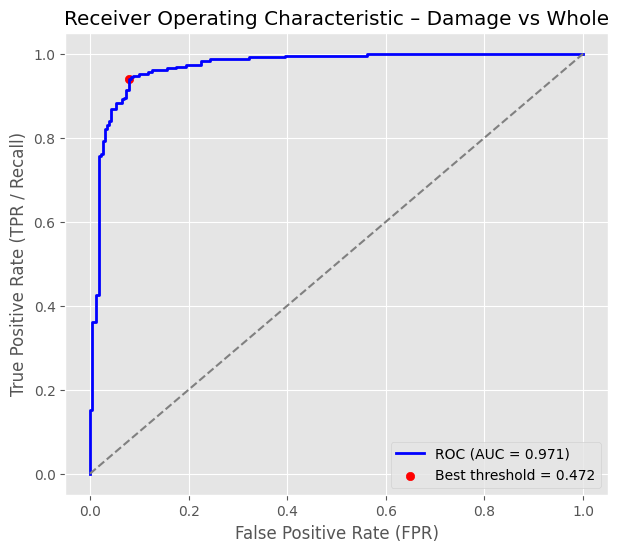

In [ ]:
# --- Import dependencies ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# --- Generate model predictions (probabilities) ---
# Each row = [prob_damage, prob_whole]
y_pred_probs = model.predict(testX, batch_size=32)

# --- Extract probability of the "damage" class (index 0) ---
damage_probs = y_pred_probs[:, 0]
true_labels = np.argmax(testY, axis=1)   # one-hot → class indices

# --- Compute ROC curve and AUC ---
fpr, tpr, thresholds = roc_curve(true_labels, damage_probs, pos_label=0)
roc_auc = auc(fpr, tpr)

# --- Find the best threshold (Youden’s J statistic) ---
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f"[INFO] Best threshold = {best_threshold:.3f}")
print(f"[INFO] Best TPR = {tpr[ix]:.3f}, Best FPR = {fpr[ix]:.3f}, AUC = {roc_auc:.3f}")

# --- Plot ROC curve ---
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="red", label=f"Best threshold = {best_threshold:.3f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title("Receiver Operating Characteristic – Damage vs Whole")
plt.legend(loc="lower right")
plt.show()

# --- Apply best threshold for final class decisions ---
y_pred_custom = (damage_probs >= best_threshold).astype(int)  # 1 = damage (predicted positive)



[INFO] Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
              precision    recall  f1-score   support

   00-damage       0.92      0.93      0.92       230
    01-whole       0.93      0.92      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460



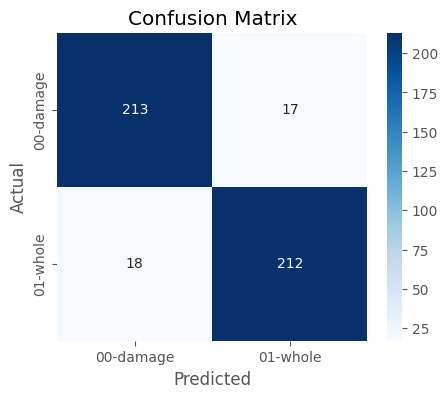

In [ ]:
# --- Evaluate model ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(testY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

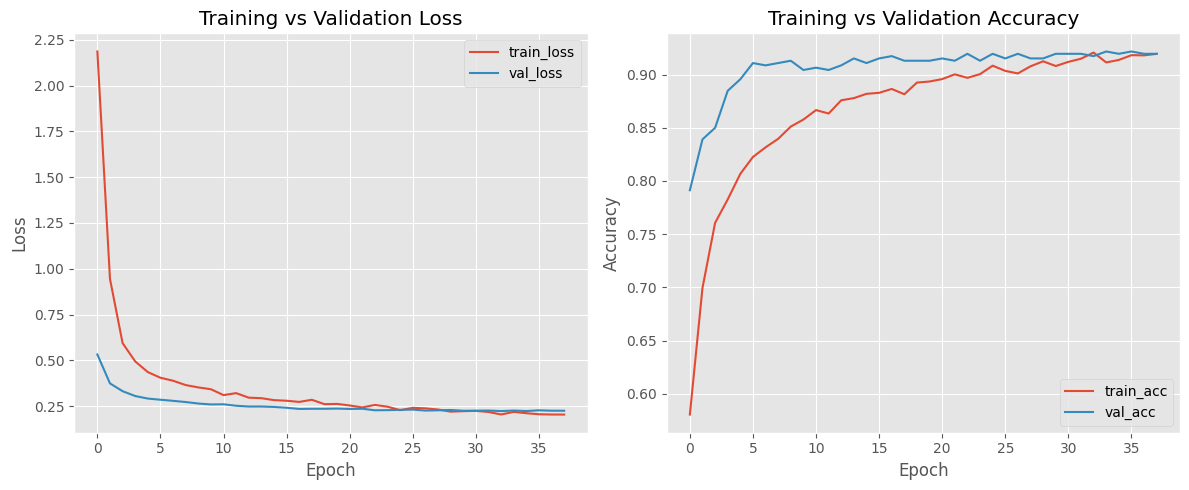

In [ ]:
# --- Plot accuracy/loss curves ---
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()